In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

import pandas as pd

import pymc3 as pm

## Functions

Pre-define the following functions.

Reference: https://github.com/krasserm/bayesian-machine-learning

In [2]:
"""pre-defined functions"""

def plot_gp(mu, cov, X, X_train=None, Y_train=None, samples=[]):
    X = X.ravel()
    mu = mu.ravel()
    uncertainty = 1.96 * np.sqrt(np.diag(cov))
    
    plt.fill_between(X, mu + uncertainty, mu - uncertainty, alpha=0.1)
    plt.plot(X, mu, label='Mean')
    for i, sample in enumerate(samples):
        plt.plot(X, sample, lw=1, ls='--', label=f'Sample {i+1}')
    if X_train is not None:
        plt.plot(X_train, Y_train, 'rx')
    plt.legend()


def kernel(X1, X2, l=1.0, sigma_f=1.0):
    '''
    Args:
        X1: Array of m points (m x d).
        X2: Array of n points (n x d).

    Returns:
        Covariance matrix (m x n).
    '''
    sqdist = np.sum(X1**2, 1).reshape(-1, 1) + np.sum(X2**2, 1) - 2 * np.dot(X1, X2.T)
    return sigma_f**2 * np.exp(-0.5 / l**2 * sqdist)

from numpy.linalg import inv

def posterior_predictive(X_s, X_train, Y_train, l=1.0, sigma_f=1.0, sigma_y=1e-8):
    '''
    Computes the suffifient statistics of the GP posterior predictive distribution 
    from m training data X_train and Y_train and n new inputs X_s.
    
    Args:
        X_s: New input locations (n x d).
        X_train: Training locations (m x d).
        Y_train: Training targets (m x 1).
        l: Kernel length parameter.
        sigma_f: Kernel vertical variation parameter.
        sigma_y: Noise parameter.
    
    Returns:
        Posterior mean vector (n x d) and covariance matrix (n x n).
    '''
    K = kernel(X_train, X_train, l, sigma_f) + sigma_y**2 * np.eye(len(X_train))
    K_s = kernel(X_train, X_s, l, sigma_f)
    K_ss = kernel(X_s, X_s, l, sigma_f) + 1e-8 * np.eye(len(X_s))
    K_inv = inv(K)
    
    mu_s = K_s.T.dot(K_inv).dot(Y_train)

    cov_s = K_ss - K_s.T.dot(K_inv).dot(K_s)
    
    return mu_s, cov_s

## Data Generation

Generate the training data with noise included.

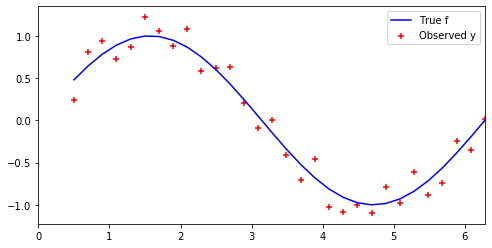

In [3]:
np.random.seed(708)
x = np.linspace(0.5, np.pi * 2, 30)
# 0.5: amplitude of noise
y = np.sin(x) + np.random.rand(30) * 0.5 - 0.25
true_y = np.sin(x)
plt.figure(figsize=(8, 4))
plt.xlim(0, np.pi * 2)
plt.scatter(x, y, marker='+', c='r', label='Observed y')
plt.plot(x, true_y, 'b', label='True f')
plt.legend(loc='best')
plt.show()

## Simulation

Simulate kernel parameters $l$ and $\sigma_f$ by MCMC using PyMC3.

Recall, the squared exponential kernel is 
$$
\kappa(\mathbf{x}_i,\mathbf{x}_j) = \sigma_f^2 \exp(-\frac{1}{2l^2}
  (\mathbf{x}_i - \mathbf{x}_j)^T
  (\mathbf{x}_i - \mathbf{x}_j))
$$

The length parameter $l$ controls the smoothness of the function and $\sigma_f$ the vertical variation.

In [4]:
# simulate parameters in kernel function by MCMC using PyMC3
with pm.Model() as model:
    amp = pm.HalfCauchy("amp", 1)
    ls = pm.HalfCauchy("ls", 1)
    cov_func = amp ** 2 * pm.gp.cov.ExpQuad(1, ls)  # input_dim=1,ls=ls
    M = pm.gp.mean.Linear(coeffs=(y / x).mean())
    gp = pm.gp.Marginal(M, cov_func)
    noise = pm.HalfCauchy("noise", 2)
    gp.marginal_likelihood("f", X=x.reshape(-1,1), y=y, noise=noise)
    trace = pm.sample(1000, chains=1)

/opt/anaconda3/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/opt/anaconda3/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
/opt/anaconda3/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)

/opt/anaconda3/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 7 seconds.
/opt/anaconda3/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
Only one chain was sampled, this makes it impossible to run some convergence checks


In [5]:
# find the Maximum A Prior of l, sigma_f and noise
map_ = pm.find_MAP(model=model)

/opt/anaconda3/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
/opt/anaconda3/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x


/opt/anaconda3/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x


In [6]:
map_

{'amp_log__': array(-0.08125971),
 'ls_log__': array(0.52298939),
 'noise_log__': array(-1.78637889),
 'amp': array(0.92195422),
 'ls': array(1.68706341),
 'noise': array(0.16756585)}

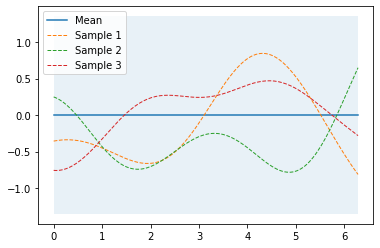

In [7]:
x = np.linspace(0.5, np.pi * 2, 30).reshape(-1,1)
X_new = np.linspace(0, np.pi * 2, 150).reshape(-1, 1)

# mean and covariance of the prior whose parameters are MAP of l and sigma_f 
mu = np.zeros(X_new.shape)
cov = kernel(X_new, X_new, l=1.42, sigma_f=0.69)

# draw three samples from the prior
samples = np.random.multivariate_normal(mu.ravel(), cov, 3)

# plot GP mean, confidence interval and samples 
plot_gp(mu, cov, X_new, samples=samples)

## Plot posterior predictive GP: Method 1

The mean and covariance of the posterior predictive distribution is computed by formula:

A GP prior $p(\mathbf{f} \lvert \mathbf{X})$ can be converted into a GP posterior $p(\mathbf{f} \lvert \mathbf{X},\mathbf{y})$ after having observed some data $\mathbf{y}$. The posterior can then be used to make predictions $\mathbf{f}_*$ given new input $\mathbf{X}_*$:

$$
\begin{align*}
p(\mathbf{f}_* \lvert \mathbf{X}_*,\mathbf{X},\mathbf{y}) 
&= \int{p(\mathbf{f}_* \lvert \mathbf{X}_*,\mathbf{f})p(\mathbf{f} \lvert \mathbf{X},\mathbf{y})}\ d\mathbf{f} \\ 
&= \mathcal{N}(\mathbf{f}_* \lvert \boldsymbol{\mu}_*, \boldsymbol{\Sigma}_*)\tag{2}\label{eq2}
\end{align*}
$$

Equation $(2)$ is the posterior predictive distribution which is also a Gaussian with mean $\boldsymbol{\mu}_*$ and $\boldsymbol{\Sigma}_*$. By definition of the GP, the joint distribution of observed data $\mathbf{y}$ and predictions $\mathbf{f}_*$  is

$$
\begin{pmatrix}\mathbf{y} \\ \mathbf{f}_*\end{pmatrix} \sim \mathcal{N}
\left(\boldsymbol{0},
\begin{pmatrix}\mathbf{K}_y & \mathbf{K}_* \\ \mathbf{K}_*^T & \mathbf{K}_{**}\end{pmatrix}
\right)\tag{3}\label{eq3}
$$

With $N$ training data and $N_*$ new input data, $\mathbf{K}_y = \kappa(\mathbf{X},\mathbf{X}) + \sigma_y^2\mathbf{I} = \mathbf{K} + \sigma_y^2\mathbf{I}$ is $N \times N$, $\mathbf{K}_* = \kappa(\mathbf{X},\mathbf{X}_*)$ is $N \times N_*$ and $\mathbf{K}_{**} = \kappa(\mathbf{X}_*,\mathbf{X}_*)$ is $N_* \times N_*$. $\sigma_y^2$ is the noise term in the diagonal of $\mathbf{K_y}$. It is set to zero if training targets are noise-free and to a value greater than zero if observations are noisy. The mean is set to $\boldsymbol{0}$ for notational simplicity. The sufficient statistics of the posterior predictive distribution, $\boldsymbol{\mu}_*$ and $\boldsymbol{\Sigma}_*$, can be computed with<sup>[1][3]</sup>

$$
\begin{align*}
\boldsymbol{\mu_*} &= \mathbf{K}_*^T \mathbf{K}_y^{-1} \mathbf{y}\tag{4}\label{eq4} \\
\boldsymbol{\Sigma_*} &= \mathbf{K}_{**} - \mathbf{K}_*^T \mathbf{K}_y^{-1} \mathbf{K}_*\tag{5}\label{eq5}
\end{align*}
$$



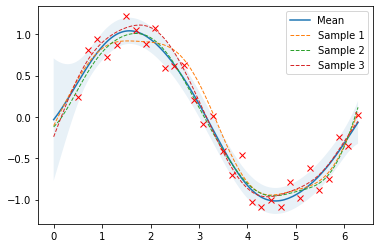

In [8]:
# compute mean and covariance of the posterior predictive distribution
mu_s, cov_s = posterior_predictive(X_new, x, y, sigma_y=0.17)

samples = np.random.multivariate_normal(mu_s.ravel(), cov_s, 3)
plot_gp(mu_s, cov_s, X_new, X_train=x, Y_train=y, samples=samples)

## Plot posterior predictive GP: Method 2

Using `.sample_posterior_predictive` method in PyMC3 to sample the posterior predictive GP. This function will randomly draw 3 samples of parameters from the trace. Then, for each sample, it will draw 150 (length of `X_new`) random numbers from a GP specified by the values of $l$ and $\sigma_f$ in that sample.

Here, I set `pred_noise = False` so that the `.conditional` method produces the predictive distribution for the underlying function represented by the GP.

In [9]:
with model:
    f_pred = gp.conditional("f_pred", X_new, pred_noise=False)
with model:
    sample_f_pred = pm.sample_posterior_predictive(trace, vars=[f_pred], samples=3)

/opt/anaconda3/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
/opt/anaconda3/lib/python3.7/site-packages/pymc3/sampling.py:1618: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "


/opt/anaconda3/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
/opt/anaconda3/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x


In [10]:
mu, var = gp.predict(X_new, point=map_, diag=True, pred_noise=False)
sd = np.sqrt(var)

/opt/anaconda3/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
/opt/anaconda3/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x


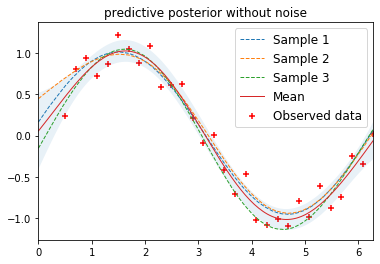

In [13]:
# draw plot
#plt.ylim(-2, 2)
plt.xlim(0, np.pi * 2)

# plot generated curves
for i, sample in enumerate(sample_f_pred['f_pred']):
    plt.plot(X_new, sample, lw=1, ls='--', label=f'Sample {i+1}')
    
# plot original data and true function
plt.scatter(x, y, alpha=1, c="r", label="Observed data", marker='+')
plt.plot(X_new, mu, lw=1, label="Mean")
plt.fill_between(X_new.flatten(), mu - 2 * sd, mu + 2 * sd, alpha=0.1)
plt.title("predictive posterior without noise",fontsize=12)
plt.legend(loc='best', fontsize=12)
plt.show()